In [1]:
import sys
sys.path.append("../")

import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
import scipy.interpolate as inter
from scipy.stats import norm
from rl.function_approx import *
from dataclasses import dataclass, replace, field
from typing import Callable, Tuple, List, Sequence, Iterable, TypeVar, Iterator
from operator import itemgetter
from collections import defaultdict

np.set_printoptions(formatter={'float': lambda x: "{0:.3f}".format(x)})
plt.rcParams['figure.figsize'] = (15, 7)

# Question 1
- this was adapted from the BSpline approx function in the [RL Github](https://github.com/TikhonJelvis/RL-book/blob/1d40c08f4d09db1e000a8298271141e92fffc76d/rl/function_approx.py#L384):

In [2]:
X = TypeVar('X')

@dataclass(frozen=True)
class BSplineApprox(FunctionApprox[X]):
    degree : int = 3
    feature_function : Callable[[X], float] = lambda x : x
    coefficients : np.ndarray = np.ndarray([])
    knots : np.ndarray = np.ndarray([])

    def get_feature(self, x_seq : Iterable[X]) -> Sequence[float]:
        return [self.feature_function(x) for x in x_seq]

    def solve(self, xy_seq : Iterable[Tuple[X, float]]) : #-> BSplineApprox[X]:
        '''
        this will calculate the new knots and 
        coefficients for our spline when called
        '''
        return self.update(xy_seq)

    def update(self, xy_seq : Iterable[Tuple[X, float]]) : #-> BSplineApprox[X]:
        '''
        first create our feature, sort the pairs
        and then create a new spline and return
        the resulting knots/coefficients
        '''
        x, y = zip(*xy_seq)
        f : List[float] = self.get_feature(x)
        pairs : Sequence[Tuple[float, float]] = sorted(zip(f, y), key = lambda x : x[0])
        new_k, new_c, _ = inter.splrep([x for x, _ in pairs], [y for _, y in pairs], k = self.degree)

        return replace(self, knots=new_k, coefficients=new_c)

    def evaluate(self, x_seq : Iterable[X]) -> np.ndarray:
        '''
        evaluate the spline at the given values 
        '''
        spline = inter.BSpline(t = self.knots, c = self.coefficients, k = self.degree)
        return spline(self.get_feature(x_seq))
    
    def within(self, other : FunctionApprox[X], tolerance : float) -> bool:
        if isinstance(other, BSplineApprox):
            return np.all(np.abs(self.knots - other.knots) <= tolerance).item() \
                and np.all(np.abs(self.coefficients - other.coefficients) <= tolerance).item()

        return False

    def __add__(self, other):
        return replace(self, knots = self.knots, coefficients = self.coefficients + other.coefficients, degree = self.degree)

    def __mul__(self, scalar : float):
        return replace(self, knots = self.knots, coefficients = scalar * self.coefficients, degree = self.degree)

    def objective_gradient(self, xy_seq, obj_deriv_out_func):
        pass

    def update_with_gradient(self, gradient):
        pass

### Create a model data generator and then create my sample function, train and test data

In [3]:
def model_data_generator(func : Callable[[float], float], 
                         var : float,
                         low : Optional[int] = 0, 
                         high : Optional[int] = 10, 
                         SEED : Optional[int] = None) -> Iterator[Tuple[float, float]]:
    if SEED:
        np.random.seed(SEED)

    err = norm(loc = 0.0, scale = np.sqrt(var))

    while True:
        x = np.random.uniform(low = low, high = high)
        y = func(x) + err.rvs(size=1)[0]

        yield (x, y)

def data_seq_generator(
    data_generator: Iterator[Tuple[float, float]],
    num_pts: int
) -> Iterator[Sequence[Tuple[float, float]]]:
    while True:
        pts: Sequence[Tuple[float, float]] = list(islice(data_generator, num_pts))
        yield pts

In [4]:
low = 0
high = 5
variance = 0.2
f = lambda x : 3 * np.cos(3 - x) - 1

training_size: int = 200
test_size: int = 300
data_gen: Iterator[Tuple[float, float]] = model_data_generator(func=f, var=variance, low=low, high=high)

train_data: Sequence[Tuple[float, float]] = list(islice(data_gen, training_size))
test_data: Sequence[Tuple[float, float]] = list(islice(data_gen, test_size))

### See how the plot looks like

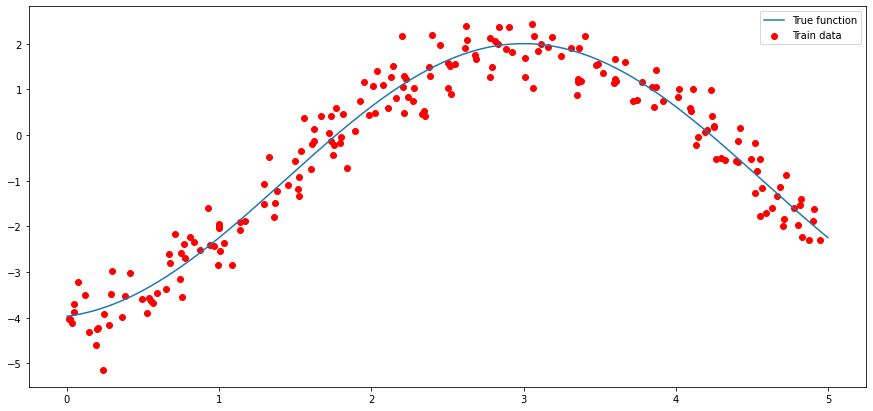

In [5]:
xx = np.linspace(low, high, 200)
yy = f(xx)

plt.plot(xx, yy, label = 'True function')
plt.scatter([x for x, _ in train_data], [y for _, y in train_data], color = 'red', label = 'Train data')
# plt.scatter([x for x, _ in test_data], [y for _, y in test_data], color = 'green', label = 'Test data')

plt.legend()
plt.show()

### See how the predictions on the test data look like

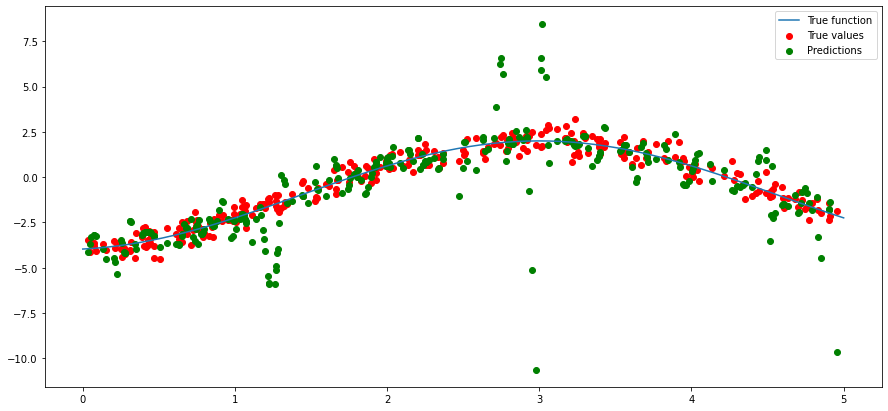

In [6]:
spline_approx = BSplineApprox(feature_function=lambda x : x, degree=3).update(train_data)

predicted = spline_approx.evaluate([x for x, _ in test_data])

xx = np.linspace(low, high, 200)
yy = f(xx)

plt.plot(xx, yy, label = 'True function')
plt.scatter([x for x, _ in test_data], [y for _, y in test_data], color = 'red', label = 'True values')
plt.scatter([x for x, _ in test_data], predicted, color = 'green', label = 'Predictions')

plt.legend()
plt.show()

### What is the RMSE on the test data when using cubic splines?

In [7]:
rmse = np.sqrt(np.mean((predicted - [y for _, y in test_data]) ** 2))

print(f"The RMSE in making the predictions on the test data is {rmse:.3f}")

The RMSE in making the predictions on the test data is 1.575


### See how the predictions look when using varying degrees:

The RMSE for using degree 1 is 0.01759.
The RMSE for using degree 2 is 0.15066.
The RMSE for using degree 3 is 0.16724.


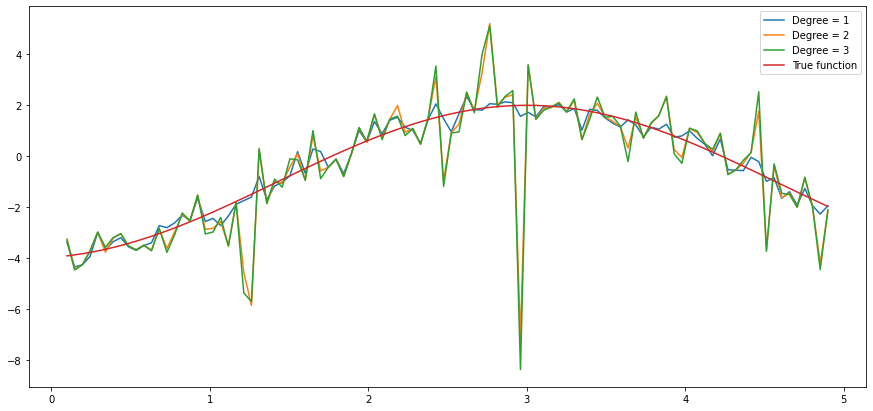

In [8]:
eps = 0.1

xx = np.linspace(low + eps, high - eps, 100)
yy = f(xx)

for d in range(1, 4):
    spline_approx = BSplineApprox(feature_function=lambda x : x, degree=d).update(train_data)
    yy_ = spline_approx.evaluate(xx)
    print(f"The RMSE for using degree {d} is {np.sqrt(np.mean(yy_ - yy) ** 2):.5f}.")
    plt.plot(xx, yy_, label = f'Degree = {d}')

plt.plot(xx, yy, label = 'True function')
plt.legend()
plt.show()